# CS 492 Project
## FactOrFake : Fake News Detection Using Machine Learning Algorithms 

### 1. Data Collection and Preprocessing

In [1]:
import pandas as pd
import itertools
import nltk
import re
import pickle
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score
%matplotlib inline

The first dataset used is the FakeNewsNet Dataset, it has 4 files, fake and real news datasets from PotiFact and GossipCop each.

In [2]:
df_poltifake = pd.read_csv("Datasets\FakeNewsNet\dataset\politifact_fake.csv")
df_poltifake.head()

,id,news_url,title,tweet_ids
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...


In [3]:
df_poltifake.shape

(432, 4)

In [4]:
df_poltifake['news_url'].nunique()

428

It seems as if there is not much repetition in terms of url, they are mostly unique, so it won't be of much use in this dataset as a feature. Still we will keep them for now, in case it proves to be useful in future datasets.

In [5]:
# Adding target column, fake = 0 means its fact and fake = 1, means it's a fake news article
df_poltifake['fake'] = 1

In [6]:
df_poltifake.head()

,id,news_url,title,tweet_ids,fake
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,1
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,1
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,1
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,1
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,1


In [7]:
df_poltifake.drop(df_poltifake.columns[[0,3]],axis=1,inplace=True)

Dataset after selecting only the required features.

In [8]:
df_poltifake.head()

,news_url,title,fake
0,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,1
1,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,1
2,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,1
3,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,1
4,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,1


In [9]:
# Dropping rows with null values
df_poltifake.dropna()
df_poltifake.shape

(432, 3)

The major preprocessing steps used for individual datasets are: 
* Adding fake column
* Dropping rows with null values
* Selecting only the required features
* Updating feature names as required

Same is repeated for other datasets with a few changes as needed.

In [10]:
df = pd.read_csv("Datasets\FakeNewsNet\dataset\politifact_real.csv")
df.dropna(inplace=True)
df['fake'] = 0
df.drop(df.columns[[0,3]],axis=1,inplace=True)
df.head()

,news_url,title,fake
0,http://www.nfib-sbet.org/,National Federation of Independent Business,0
1,http://www.cq.com/doc/newsmakertranscripts-494...,comments in Fayetteville NC,0
4,https://web.archive.org/web/20070820164107/htt...,"Budget of the United States Government, FY 2008",0
5,http://www.politifact.com/truth-o-meter/statem...,Donald Trump exaggerates when he says China ha...,0
6,https://www.law.cornell.edu/constitution/amend...,25th Amendment,0


In [11]:
df.shape

(373, 3)

Now, we are iteratively gonna combine the individual preprocessed datasets to get a large dataset.

In [12]:
df_combined = pd.concat([df_poltifake,df])
df_combined.shape

(805, 3)

In [13]:
df = pd.read_csv("Datasets\FakeNewsNet\dataset\gossipcop_real.csv")
df.head()

,id,news_url,title,tweet_ids
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,912371411146149888\t912371528343408641\t912372...
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,Kylie Jenner refusing to discuss Tyga on Life ...,901989917546426369\t901989992074969089\t901990...
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,Quinn Perkins,931263637246881792\t931265332022579201\t931265...
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,I Tried Kim Kardashian's Butt Workout & Am For...,868114761723936769\t868122567910936576\t868128...
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,Celine Dion donates concert proceeds to Vegas ...,915528047004209152\t915529285171122176\t915530...


In [14]:
df.dropna(inplace=True)
df['fake'] = 0
df.drop(df.columns[[0,3]],axis=1,inplace=True)
df.head()

,news_url,title,fake
0,https://www.brides.com/story/teen-mom-jenelle-...,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,0
1,https://www.dailymail.co.uk/tvshowbiz/article-...,Kylie Jenner refusing to discuss Tyga on Life ...,0
2,https://en.wikipedia.org/wiki/Quinn_Perkins,Quinn Perkins,0
3,https://www.refinery29.com/en-us/2018/03/19192...,I Tried Kim Kardashian's Butt Workout & Am For...,0
4,https://www.cnn.com/2017/10/04/entertainment/c...,Celine Dion donates concert proceeds to Vegas ...,0


In [15]:
df.shape

(15747, 3)

In [16]:
df_combined = pd.concat([df_combined,df])
df_combined.shape

(16552, 3)

In [17]:
df = pd.read_csv("Datasets\FakeNewsNet\dataset\gossipcop_fake.csv")
df['fake'] = 1
df.drop(df.columns[[0,3]],axis=1,inplace=True)
df.dropna(inplace=True)
df.head()

,news_url,title,fake
0,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,1
1,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,1
2,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,1
3,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,1
4,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,1


In [18]:
df.shape

(5067, 3)

In [19]:
df_combined = pd.concat([df_combined,df])
df_fakenewsnet = df_combined
df_combined.shape

(21619, 3)

In [20]:
df_combined.rename(columns = {'title':"content"}, inplace = True)

In [21]:
df_combined.head()

,news_url,content,fake
0,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,1
1,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,1
2,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,1
3,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,1
4,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,1


Next dataset in use  : Getting Real About Fake News (only contains fake news).

In [22]:
df_fake = pd.read_csv("Datasets/getting_real_about_fake_news/fake.csv")
df_fake.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [23]:
df_fake.shape

(12999, 20)

Multiple languages are there, so we are selecting only English

In [24]:
df_fake=df_fake[df_fake["language"]=="english"]

In [25]:
df_fake.shape

(12403, 20)

In [26]:
df_fake["content"] = df_fake["thread_title"]+df_fake["text"]
df_fake_new=df_fake.loc[:,["site_url","content"]]
df_fake_new["fake"]=1
df_fake_new.shape

(12403, 3)

In [27]:
df_fake_new.head()

,site_url,content,fake
0,100percentfedup.com,Muslims BUSTED: They Stole Millions In Gov’t B...,1
1,100percentfedup.com,Re: Why Did Attorney General Loretta Lynch Ple...,1
2,100percentfedup.com,BREAKING: Weiner Cooperating With FBI On Hilla...,1
3,100percentfedup.com,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,1
4,100percentfedup.com,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,1


Renaming the column names to match the combined dataset

In [28]:
df_fake_new.rename(columns = {'site_url':'news_url'}, inplace = True)
df_fake_new.head()

,news_url,content,fake
0,100percentfedup.com,Muslims BUSTED: They Stole Millions In Gov’t B...,1
1,100percentfedup.com,Re: Why Did Attorney General Loretta Lynch Ple...,1
2,100percentfedup.com,BREAKING: Weiner Cooperating With FBI On Hilla...,1
3,100percentfedup.com,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,1
4,100percentfedup.com,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,1


In [29]:
df_fake_new.groupby('news_url').count()

,content,fake
news_url,,
100percentfedup.com,33,33
21stcenturywire.com,24,24
abcnews.com.co,2,2
abeldanger.net,96,100
abovetopsecret.com,100,100
...,...,...
worldnewspolitics.com,1,1
worldtruth.tv,100,100
wundergroundmusic.com,2,2


As seen above, url is repeated.

In [30]:
df_fake_new['news_url'].nunique()

237

In [31]:
df_combined=pd.concat([df_combined,df_fake_new])
df_combined.shape

(34022, 3)

In [32]:
df_combined.head()

,news_url,content,fake
0,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,1
1,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,1
2,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,1
3,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,1
4,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,1


Next few datasets contain news regarding Covid !9, both real and fake.

In [33]:
df_fake = pd.read_csv("Datasets/Covid 19/NewsFakeCOVID-19.csv")
df_fake.head()

,Unnamed: 0,type,fact_check_url,archieve,news_url,news_url2,news_url3,news_url4,news_url5,title,newstitle,content,abstract,publish_date,meta_keywords
0,889,post,https://healthfeedback.org/claimreview/false-c...,https://archive.is/geT2g,https://www.facebook.com/drelizabethdc/posts/1...,NaN,NaN,NaN,NaN,The U.S. CDC quietly updated their numbers in ...,"""Log In or Sign Up to View""",you must log in to continue ..,NaN,NaN,""""""
1,890,post,https://factcheck.afp.com/trump-retweets-false...,http://archive.is/pZ2Pk,https://twitter.com/littllemel/status/12997914...,NaN,NaN,NaN,NaN,Social media posts shared thousands of times a...,"""""",we 've detected that javascript is disabled in...,NaN,NaN,""""""
2,891,NaN,https://www.factcheck.org/2020/09/cdc-did-not-...,https://projects.propublica.org/politwoops/twe...,NaN,NaN,NaN,NaN,NaN,The CDC updated the COVID-19 number to admit t...,NaN,NaN,NaN,NaN,NaN
3,892,post,https://healthfeedback.org/claimreview/masks-o...,https://archive.vn/k8PJk,https://www.facebook.com/120381895036072/posts...,NaN,NaN,NaN,NaN,Either masks work or they don’t; if masks work...,"""Log In or Sign Up to View""",do you want to join facebook ?.,NaN,NaN,""""""
4,893,article,https://healthfeedback.org/claimreview/human-d...,https://archive.is/Af8Xi,https://pieceofmindful.com/2020/04/06/bombshel...,NaN,NaN,NaN,NaN,The RT-PCR test for the virus that causes COVI...,"""BOMBSHELL: WHO Coronavirus PCR Test Primer Se...",this was important enough that i wanted to get...,this was important enough that i wanted to get...,2020-04-06T17:27:39+00:00,""""""


In [34]:
df_fake.shape

(56, 15)

In [35]:
df_fake = df_fake.dropna(subset = ['news_url'])
df_fake = df_fake.dropna(subset = ['title'])
df_fake = df_fake.dropna(subset = ['content'])
df_fake.shape

(47, 15)

In [36]:
df_fake['content'] += df_fake['title']
df_fake = df_fake.loc[:,['news_url','content']]

In [37]:
df_fake['fake'] = 1
df_fake.head()

,news_url,content,fake
0,https://www.facebook.com/drelizabethdc/posts/1...,you must log in to continue .. The U.S. CDC qu...,1
1,https://twitter.com/littllemel/status/12997914...,we 've detected that javascript is disabled in...,1
3,https://www.facebook.com/120381895036072/posts...,do you want to join facebook ?. Either masks w...,1
4,https://pieceofmindful.com/2020/04/06/bombshel...,this was important enough that i wanted to get...,1
5,https://summit.news/2020/08/20/governor-of-mai...,governor of maine has ordered restaurant staff...,1


In [38]:
df_fake['news_url'].nunique()

46

In [39]:
df_combined=pd.concat([df_combined,df_fake])
df_combined.shape

(34069, 3)

In [40]:
df_fake = pd.read_csv("Datasets/Covid 19/NewsFakeCOVID-19_5.csv")
df_fake.head()

,Unnamed: 0,type,fact_check_url,archieve,news_url,news_url2,news_url3,news_url4,news_url5,title,newstitle,content,abstract,publish_date,meta_keywords
0,0,post,https://factcheck.afp.com/false-advice-refusin...,https://perma.cc/J4N6-39D5,https://www.facebook.com/photo.php?fbid=551960...,NaN,NaN,NaN,NaN,Facebook posts shared in at least three countr...,NaN,NaN,NaN,NaN,NaN
1,1,article,https://www.politifact.com/factchecks/2020/apr...,NaN,http://legis.wisconsin.gov/assembly/republican...,NaN,NaN,NaN,NaN,Wisconsin is Òclearly seeing a decline in COVI...,"""Wisconsin Legislature Takes Gov. Evers to Court""",speaker robin vos r rochester and senate major...,NaN,NaN,""""""
2,2,post,https://factcheck.afp.com/posts-claim-children...,https://perma.cc/V4HX-M2XJ,https://www.facebook.com/iAmJessenia/photos/a....,NaN,NaN,NaN,NaN,Facebook posts claim a child who is infected w...,NaN,NaN,NaN,NaN,NaN
3,3,post,https://checkyourfact.com/2020/04/20/fact-chec...,NaN,https://www.facebook.com/kokernagnews/photos/a...,NaN,NaN,NaN,NaN,IndiaÕs Ministry of Home Affairs banning citiz...,NaN,NaN,NaN,NaN,NaN
4,5,post,https://checkyourfact.com/2020/04/20/fact-chec...,NaN,https://www.facebook.com/photo.php?fbid=102193...,NaN,NaN,NaN,NaN,"42 Democratic senators, plus two Independents,...",NaN,NaN,NaN,NaN,NaN


In [41]:
df_fake.shape

(572, 15)

In [42]:
df_fake = df_fake.dropna(subset = ['news_url'])
df_fake = df_fake.dropna(subset = ['title'])
df_fake = df_fake.dropna(subset = ['content'])
df_fake.shape

(125, 15)

In [43]:
df_fake['content'] += df_fake['title']
df_fake = df_fake.loc[:,['news_url','content']]

In [44]:
df_fake['news_url'].nunique()

117

In [45]:
df_fake['fake'] = 1
df_fake.head()

,news_url,content,fake
1,http://legis.wisconsin.gov/assembly/republican...,speaker robin vos r rochester and senate major...,1
14,https://secondnexus.com/wisconsin-gop-new-case...,this is not the page you 're looking for .. Sa...,1
15,https://www.gilmorehealth.com/chinese-coronavi...,contrary to the narrative that is being pushed...,1
24,https://www.theepochtimes.com/programming-aler...,programming alert exclusive documentary on ori...,1
30,https://www.wivb.com/news/watch-interview-with...,buffalo n.y. wivb)--mayor byron brown was hand...,1


In [46]:
df_combined=pd.concat([df_combined,df_fake])
df_combined.shape

(34194, 3)

In [47]:
df_fake = pd.read_csv("Datasets/Covid 19/NewsFakeCOVID-19_7.csv")
df_fake.head()

,Unnamed: 0,type,fact_check_url,archieve,news_url,news_url2,news_url3,news_url4,news_url5,title,newstitle,content,abstract,publish_date,meta_keywords
0,623,post,https://www.factcheck.org/2020/07/face-mask-ex...,http://archive.is/LC508,https://www.facebook.com/tednugent/photos/a.10...,NaN,NaN,NaN,NaN,A “face mask exempt card” shared on social med...,"""Ted Nugent""",snag limbrats that daddy 22s out of the toweri...,ted nugent added a new photo ..,NaN,""""""
1,624,post,https://www.factcheck.org/2020/07/video-presen...,http://archive.is/l3qLv,https://www.facebook.com/jeff.neff.528/videos/...,NaN,NaN,NaN,NaN,A test on video with a gas detector shows that...,"""Jeff""",see more of jeff neff on facebook.,face masks you decide. this is worth a few min...,NaN,""""""
2,625,post,https://www.factcheck.org/2020/06/painting-of-...,http://archive.is/vv6OB,https://twitter.com/SexCounseling/status/12764...,https://www.facebook.com/photo.php?fbid=102138...,https://www.facebook.com/112390917148814/posts...,NaN,NaN,A painting depicting children in face masks wa...,"""""",we 've detected that javascript is disabled in...,NaN,NaN,""""""
3,626,article,https://healthfeedback.org/claimreview/contrar...,https://archive.is/51Jn0,https://www.wakingtimes.com/2020/05/15/bill-ga...,NaN,NaN,NaN,NaN,According to Bill Gates the COVID-19 RNA vacci...,"""403 Forbidden""",NaN,NaN,NaN,""""""
4,627,post,https://www.factcheck.org/2020/06/meme-misrepr...,NaN,https://www.facebook.com/photo.php?fbid=424048...,NaN,NaN,NaN,NaN,Meme shows Florida Surgeon General saying: Eve...,"""Jeff Cloud""",see more of jeff cloud on facebook.,it 's all coming out now .....,NaN,""""""


In [48]:
df_fake.shape

(266, 15)

In [49]:
df_fake = df_fake.dropna(subset = ['news_url'])
df_fake = df_fake.dropna(subset = ['title'])
df_fake = df_fake.dropna(subset = ['content'])
df_fake.shape

(225, 15)

In [50]:
df_fake['content']+=df_fake['title']
df_fake = df_fake.loc[:,['news_url','content']]

In [51]:
df_fake['news_url'].nunique()

216

In [52]:
df_fake['fake'] = 1
df_fake.head()

,news_url,content,fake
0,https://www.facebook.com/tednugent/photos/a.10...,snag limbrats that daddy 22s out of the toweri...,1
1,https://www.facebook.com/jeff.neff.528/videos/...,see more of jeff neff on facebook. A test on v...,1
2,https://twitter.com/SexCounseling/status/12764...,we 've detected that javascript is disabled in...,1
4,https://www.facebook.com/photo.php?fbid=424048...,see more of jeff cloud on facebook. Meme shows...,1
5,https://www.facebook.com/photo.php?fbid=101569...,see more of theresa ivancik on facebook. Alexa...,1


In [53]:
df_combined=pd.concat([df_combined,df_fake])
df_combined.shape

(34419, 3)

In [54]:
df_real = pd.read_csv("Datasets/Covid 19/NewsRealCOVID-19.csv")
df_real.head()

,Unnamed: 0,type,fact_check_url,news_url,title,newstitle,content,abstract,publish_date,meta_keywords
0,2658,article,healthline.com,https://www.healthline.com/health-news/what-we...,What We Can Learn from the Resurgence of COVID...,"""What We Can Learn from the Resurgence of COVI...",experts say crowded beaches like this one in b...,experts say covid-19 cases have surged in spai...,NaN,"""spain resurgence covid19 coronavirus cases le..."
1,2659,article,healthline.com,https://www.healthline.com/health-news/why-app...,Why Approving a COVID-19 Vaccine Too Early Cou...,"""Why Approving a COVID-19 Vaccine Too Early Co...",increasing number of healthcare experts say th...,increasing number of healthcare experts say th...,NaN,"""covid-19, coronavirus, viral infection, vacci..."
2,2660,article,healthline.com,https://www.healthline.com/health-news/flu-all...,Not Sure You Have COVID-19? Here Are the Sympt...,"""Different Symptoms for Coronavirus, Flu, and ...",fatigue and body aches are symptoms of both fl...,fatigue and body aches are symptoms of both fl...,NaN,"""flu symptoms allergy symptoms coronavirus sym..."
3,2661,article,healthline.com,https://www.healthline.com/health-news/flu-stu...,Flu Study Highlights Difficulty of Achieving C...,"""Flu Study Highlights Difficulty of Achieving ...",researchers say women are more likely than men...,researchers say women are more likely than men...,NaN,"""covid19 coronavirus vaccine 80 percent effect..."
4,2662,article,healthline.com,https://www.healthline.com/health-news/resign-...,Resign or Return? The Dilemma Facing Classroom...,"""Resign or Return? The Dilemma for Classroom T...",some teachers have quit while others have sued...,as some schools are ordered to reopen many tea...,NaN,"""covid19 coronavirus school classrooms reopeni..."


In [55]:
df_real.shape

(893, 10)

In [56]:
df_real = df_real.dropna(subset = ['news_url'])
df_real = df_real.dropna(subset = ['title'])
df_real = df_real.dropna(subset = ['content'])
df_real['title'] += df_real['title']
df_real = df_real.loc[:,['news_url','content']]

In [57]:
df_real['news_url'].nunique()

800

In [58]:
df_real['fake'] = 0
df_real.head()

,news_url,content,fake
0,https://www.healthline.com/health-news/what-we...,experts say crowded beaches like this one in b...,0
1,https://www.healthline.com/health-news/why-app...,increasing number of healthcare experts say th...,0
2,https://www.healthline.com/health-news/flu-all...,fatigue and body aches are symptoms of both fl...,0
3,https://www.healthline.com/health-news/flu-stu...,researchers say women are more likely than men...,0
4,https://www.healthline.com/health-news/resign-...,some teachers have quit while others have sued...,0


In [59]:
df_combined=pd.concat([df_combined,df_real])
df_combined.shape

(35219, 3)

In [60]:
df_real = pd.read_csv("Datasets/Covid 19/NewsRealCOVID-19_5.csv")
df_real.head()

,Unnamed: 0,type,fact_check_url,news_url,title,newstitle,content,abstract,publish_date,meta_keywords
0,0,article,healthline.com,https://www.healthline.com/health-news/coronav...,Coronavirus Outbreak: Live Updates,"""Coronavirus Outbreak: Daily Updates""",experts warn most states that are reopening st...,the new coronavirus disease outbreak first ide...,NaN,"""coronavirus outbreak, viral outbreak, viral i..."
1,1,article,healthline.com,https://www.healthline.com/health-news/screen-...,"Screen Time Doesn’t Hurt Kids’ Social Skills, ...","""Screen Time Doesn't Hurt Kids' Social Skills,...",a new study finds an increase in screen time d...,new research found that school age children in...,NaN,"""screen time, child development, smartphones, ..."
2,2,article,healthline.com,https://www.healthline.com/health-news/heres-e...,Here’s Exactly Where We Are with Vaccines and ...,"""Where We're at with Vaccines and Treatments f...",scientists around the world are working on a n...,scientists around the world are working on a n...,NaN,"""covid-19 coronavirus outbreak research progre..."
3,3,article,healthline.com,https://www.healthline.com/health-news/heres-w...,Here’s What Happens to the Body After Contract...,"""Here's What Happens to the Body After Contrac...",coronaviruses cause respiratory illnesses so t...,heres what we know so far about how covid-19 a...,NaN,"""coronavirus, viral infection, viral outbreak,..."
4,4,article,healthline.com,https://www.healthline.com/health-news/why-you...,Why You Should Be Skeptical of Early Results o...,"""Why You Should Be Skeptical of Leaked Results...",medical experts are studying if remdesivir can...,with no approved treatment specific for covid-...,NaN,"""covid-19, covornavirus, novel coronavirus, vi..."


In [61]:
df_real.shape

(1590, 10)

In [62]:
df_real = df_real.dropna(subset = ['news_url'])
df_real = df_real.dropna(subset = ['title'])
df_real = df_real.dropna(subset = ['content'])
df_real['title'] += df_real['title']
df_real = df_real.loc[:,['news_url','content']]

In [63]:
df_real['news_url'].nunique()

1387

In [64]:
df_real['fake'] = 0
df_real.head()

,news_url,content,fake
0,https://www.healthline.com/health-news/coronav...,experts warn most states that are reopening st...,0
1,https://www.healthline.com/health-news/screen-...,a new study finds an increase in screen time d...,0
2,https://www.healthline.com/health-news/heres-e...,scientists around the world are working on a n...,0
3,https://www.healthline.com/health-news/heres-w...,coronaviruses cause respiratory illnesses so t...,0
4,https://www.healthline.com/health-news/why-you...,medical experts are studying if remdesivir can...,0


In [65]:
df_combined=pd.concat([df_combined,df_real])
df_combined.shape

(36616, 3)

In [66]:
df_real = pd.read_csv("Datasets/Covid 19/NewsRealCOVID-19_7.csv")
df_real.head()

,Unnamed: 0,type,fact_check_url,news_url,title,newstitle,content,abstract,publish_date,meta_keywords
0,1555,article,healthline.com,https://www.healthline.com/health-news/how-to-...,How to Enjoy the Fourth of July Weekend Amid t...,"""How to Enjoy Fourth of July Weekend Amid the ...",experts recommend everyone avoid large gatheri...,experts recommend everyone avoid large gatheri...,NaN,"""COVID19 coronavirus prevention advice July 4 ..."
1,1556,article,healthline.com,https://www.healthline.com/health-news/cdc-exp...,CDC Expands List of Those with Higher COVID-19...,"""CDC Expands List of Those with Higher COVID-1...",experts say the key is to stay in the know and...,officials at the centers for disease control a...,NaN,"""CDC list expanded COVID-19 coronavirus higher..."
2,1557,article,healthline.com,https://www.healthline.com/health-news/feds-wa...,Feds Warn That Face Mask ‘Exemption’ Cards Are...,"""Feds Warn That Face Mask ‘Exemption’ Cards Ar...",some people have reportedly been presenting fa...,reports of people presenting cards that claim ...,NaN,"""covid 19, coronavirus, face mask exemption ca..."
3,1558,article,healthline.com,https://www.healthline.com/health-news/experts...,Experts Confident Biden’s COVID-19 Response Co...,"""Experts Confident Biden's COVID-19 Response C...",medical experts say they believe bidens plan t...,medical experts say they believe bidens plan t...,NaN,"""covid 19, coronavirus, testing and tracing"""
4,1559,article,healthline.com,https://www.healthline.com/health-news/heres-e...,Here’s Exactly Where We Are with Vaccines and ...,"""Where We're at with Vaccines and Treatments f...",scientists around the world are working on a n...,scientists around the world are working on a n...,NaN,"""covid19 coronavirus outbreak research progres..."


In [67]:
df_real.shape

(1127, 10)

In [68]:
df_real = df_real.dropna(subset = ['news_url'])
df_real = df_real.dropna(subset = ['title'])
df_real = df_real.dropna(subset = ['content'])
df_real['title'] += df_real['title']
df_real = df_real.loc[:,['news_url','content']]

In [69]:
df_real['news_url'].nunique()

986

In [70]:
df_real['fake'] = 0
df_real.head()

,news_url,content,fake
0,https://www.healthline.com/health-news/how-to-...,experts recommend everyone avoid large gatheri...,0
1,https://www.healthline.com/health-news/cdc-exp...,experts say the key is to stay in the know and...,0
2,https://www.healthline.com/health-news/feds-wa...,some people have reportedly been presenting fa...,0
3,https://www.healthline.com/health-news/experts...,medical experts say they believe bidens plan t...,0
4,https://www.healthline.com/health-news/heres-e...,scientists around the world are working on a n...,0


In [71]:
df_combined=pd.concat([df_combined,df_real])
df_combined.shape

(37603, 3)

We need to process both _title_ and *news_url*. So we  combine them into a single feature by concatenation.

In [72]:
train = df_combined.fillna(' ')
train['total'] = train['content']+train['news_url']
train.head()

,news_url,content,fake,total
0,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,1,BREAKING: First NFL Team Declares Bankruptcy O...
1,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,1,Court Orders Obama To Pay $400 Million In Rest...
2,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,1,UPDATE: Second Roy Moore Accuser Works For Mic...
3,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,1,Oscar Pistorius Attempts To Commit Suicidehttp...
4,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,1,Trump Votes For Death Penalty For Being Gayhtt...


In [73]:
g = df_combined.groupby('fake')
g.count()

,news_url,content
fake,,
0,19304,19304
1,18295,18241


### Natural Language Processing

Next, we need to remove the stop words and then perform lemmatization on the text.

In [74]:
stop_words = stopwords.words('english')
stop_words.extend(['https','http','www','com'])
len(stop_words)

183

In [75]:
lemmatizer = WordNetLemmatizer()

In [76]:
train['news_url'].nunique()

24101

In [77]:
def lemmatize_text(text):
    filter_sentence = ''
    sentence = re.sub(r'[^\w\s]', '', text)
     # Tokenization
    words = nltk.word_tokenize(sentence)
     # Stopwords removal
    words = [w for w in words if not w in stop_words]
    # Lemmatization
    for words in words:
        filter_sentence = filter_sentence  + ' ' +str(lemmatizer.lemmatize(words)).lower()
    return filter_sentence


In [78]:
train['text_lemmatized'] = train.total.apply(lemmatize_text)
train.head()

,news_url,content,fake,total,text_lemmatized
0,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,1,BREAKING: First NFL Team Declares Bankruptcy O...,breaking first nfl team declares bankruptcy o...
1,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,1,Court Orders Obama To Pay $400 Million In Rest...,court orders obama to pay 400 million in rest...
2,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,1,UPDATE: Second Roy Moore Accuser Works For Mic...,update second roy moore accuser works for mic...
3,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,1,Oscar Pistorius Attempts To Commit Suicidehttp...,oscar pistorius attempts to commit suicidehtt...
4,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,1,Trump Votes For Death Penalty For Being Gayhtt...,trump votes for death penalty for being gayht...


Now lets look at the common words in fake and real news through a word cloud representation.  
First for **real news**:

In [79]:
visual = train.text_lemmatized[train.fake == 0]
comment_words = ''
for val in visual:
    # split the value
    tokens = val.split()
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(comment_words)

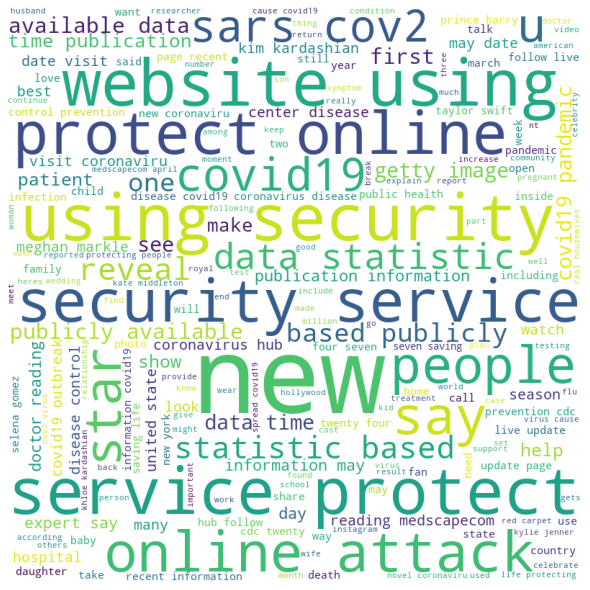

In [80]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

Now for **fake news** :

In [142]:
visual = train.text_lemmatized[train.fake == 1]
comment_words = ''
for val in visual:
    # split the value
    tokens = val.split()
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(comment_words)

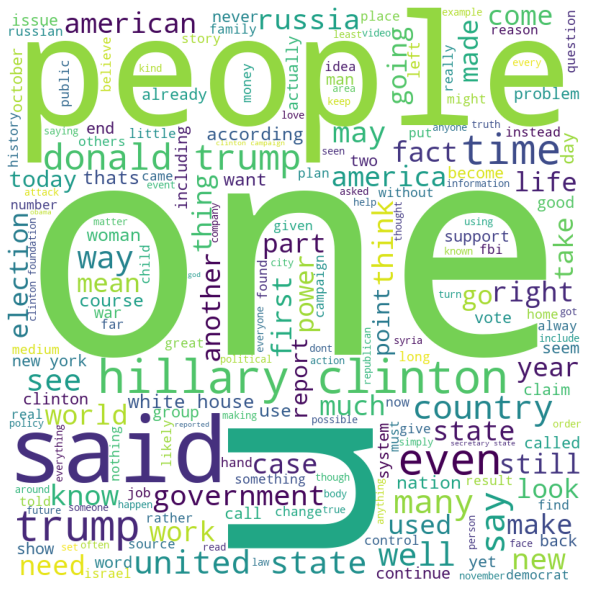

In [143]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

Next step is **Vectorization**:

In [115]:
X_train = train['text_lemmatized']
Y_train = train['fake']

In [81]:
pickle.dump(Y_train, open("training_target.csv", "wb"))

Using TF-IDF Vectorization

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [83]:
vectors = vectorizer.fit(X_train)

In [84]:
pickle.dump(vectors, open("tfidf.pickle", "wb"))

In [85]:
vectors = vectorizer.transform(X_train)

Next, split the data into training and testing sets

In [132]:
X_train, X_test, y_train, y_test = train_test_split(vectors,Y_train, test_size = 0.20)

## Training and Testing the Model

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, plot_roc_curve
import seaborn as sns
import numpy as np

In [129]:
from sklearn.model_selection import cross_val_score

### Logistic Regression

Training the model:

In [140]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
y_predicted = logreg_model.predict(X_test)

Accuracy

In [141]:
accuracy_score(y_test,y_predicted)

0.8893764127110757

Confusion Matrix

In [99]:
cm = confusion_matrix(y_test, y_predicted)
cm

array([[3682,  190],
       [ 605, 3044]], dtype=int64)

Text(33.0, 0.5, 'Truth')

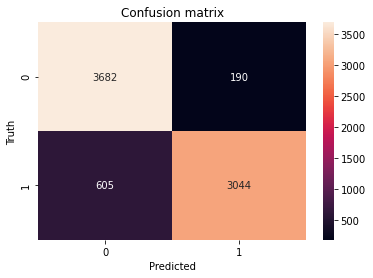

In [100]:
sns.heatmap(cm, annot=True, fmt = 'd')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Text(33.0, 0.5, 'Truth')

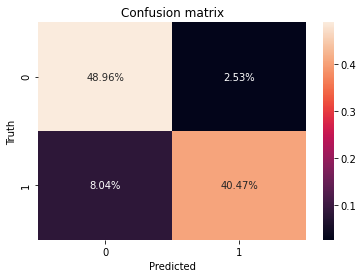

In [101]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt = '.2%')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [102]:
print("Precision Score: ", precision_score(y_test,y_predicted))
print("Recall Score: ", recall_score(y_test,y_predicted))
print("F1 Score: ",f1_score(y_test,y_predicted))
print("ROC-AUC Score: ",roc_auc_score(y_test,y_predicted))

Precision Score:  0.9412492269635127
Recall Score:  0.834201151000274
F1 Score:  0.8844980386459392
ROC-AUC Score:  0.8925654515331949


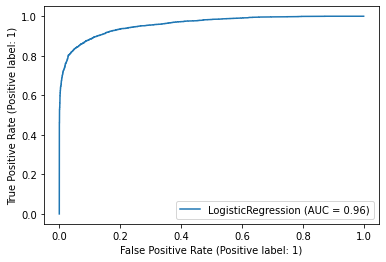

In [103]:
plot_roc_curve(logreg_model,X_test,y_test)

### Multinominal Naive Bayes

Train the model:

In [104]:
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predicted = NB_model.predict(X_test)

Accuracy

In [105]:
NB_model.score(X_test,y_test)

0.8312724371759075

Confusion Matrix

In [106]:
cm = confusion_matrix(y_test, y_predicted)
cm

array([[3092,  780],
       [ 489, 3160]], dtype=int64)

Text(33.0, 0.5, 'Truth')

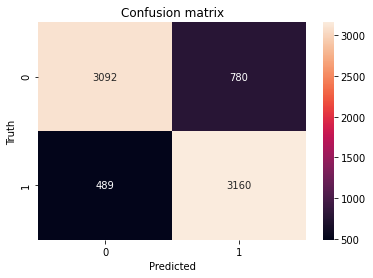

In [107]:
sns.heatmap(cm, annot=True, fmt = 'd')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Text(33.0, 0.5, 'Truth')

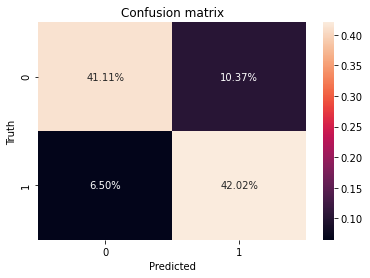

In [108]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt = '.2%')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [109]:
print("Precision Score: ", precision_score(y_test,y_predicted))
print("Recall Score: ", recall_score(y_test,y_predicted))
print("F1 Score: ",f1_score(y_test,y_predicted))
print("ROC-AUC Score: ",roc_auc_score(y_test,y_predicted))

Precision Score:  0.8020304568527918
Recall Score:  0.8659906823787339
F1 Score:  0.8327842930557384
ROC-AUC Score:  0.8322722006934992


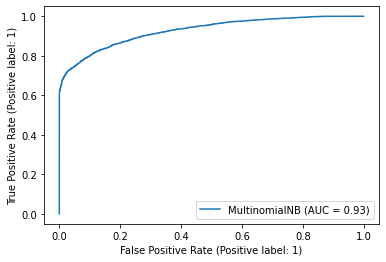

In [110]:
plot_roc_curve(NB_model,X_test,y_test)

## Save the Models

In [113]:
filename = "logreg_model.sav"
pickle.dump(logreg_model,open(filename,'wb'))

In [114]:
filename = "nb_model.sav"
pickle.dump(NB_model,open(filename,'wb'))